<a href="https://colab.research.google.com/github/wfwiggins/RSNA-NLP-2020/blob/master/RSNA20_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSNA 2020**

## **Hands-on AI for Non-Coders:** Basics of Information Extraction from Radiology Reports

In this demonstration, we will utilize techniques of _natural language processing_ (NLP) to train a classifier, which will analyze the text of radiology reports for chest radiographs to predict whether a report is **normal** or **abnormal**.

# System Setup & Downloading the Data

- The first step will install the necessary libraries, then the system will restart. This _WILL_ generate an error message, which can safely be ignored 😉.
- In the second step, we will download the [NLM Open-i "Indiana University Chest X-ray Reports" dataset](https://openi.nlm.nih.gov/faq#collection).

In [ ]:
#@title **Installing libraries & restarting...**

# Installing dependencies
import os
from IPython.display import clear_output

!pip install fastai --upgrade >/dev/null
!pip install xmltodict >/dev/null

clear_output()
os.kill(os.getpid(), 9)

In [1]:
#@title **Downloading the data...**

!curl https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz | tar xvz >/dev/null


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1086k  100 1086k    0     0   181k      0  0:00:05  0:00:05 --:--:--  243k


# Reformatting the Data

Each of the reports is stored in _extensible markup language_ (XML) format. In order to work with the report text data more easily, we will extract the data and put it into a `pandas.DataFrame`, which is a tabular data structure.

The XML metadata contains MeSH terms for each report. We will use these to create the _label_ for each report in our dataset. These labels will serve as the targets for training our classifier to predict whether the report is **normal** or **abnormal**.

In [2]:
#@title **Extracting the data...**

import glob
import xmltodict
from fastai.basics import *

def xml_parse(f):
    with open(f) as xml:
        report_dict = xmltodict.parse(xml.read())
    xml.close()
    return report_dict

def get_label(report):
    label = L(report['eCitation']['MeSH']['major'])
    return 'normal' if label[0].lower() == 'normal' else 'abnormal'

def get_text(report):
    text_dict = {}
    text = report['eCitation']['MedlineCitation']['Article']['Abstract']['AbstractText']
    findings = text[2]
    text_dict['findings'] = findings['#text'] if '#text' in findings else ''
    impression = text[3]
    text_dict['impression'] = impression['#text'] if '#text' in impression else ''
    return text_dict

def process_report(report):
    label = get_label(report)
    report_dict = get_text(report)
    report_dict['label'] = label
    return report_dict

fps = L(glob.glob('/content/ecgen-radiology/*'))
reports = fps.map(xml_parse)
reports_df = pd.DataFrame(reports.map(process_report))
reports_df

,findings,impression,label
0,,No comparison chest x-XXXX. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.,normal
1,"The heart is normal size. The mediastinum is unremarkable. There is no pleural effusion, pneumothorax, or focal airspace disease. The XXXX are unremarkable.",No acute cardiopulmonary abnormality.,normal
2,"No pneumothorax, pleural effusion or airspace consolidation. Stable right lower lung granuloma. Interval to right clavicle XXXX procedure. Heart size and pulmonary vasculature appear within normal limits. XXXX XXXX are intact.",No acute cardiopulmonary abnormality. .,abnormal
3,The lungs and pleural spaces show no acute abnormality. Heart size and pulmonary vascularity within normal limits. .,1. No acute pulmonary abnormality.,normal
4,"The heart is normal in size and contour. There is no mediastinal widening. The lungs are clear bilaterally. No large pleural effusion or pneumothorax. Mild dextro curvature of the thoracic spine, possibly positional.",No acute cardiopulmonary abnormalities.,abnormal
...,...,...,...
3950,Stable cardiomegaly. The lungs are clear. Stable left lung base calcifications. No focal consolidations. No pneumothorax or pleural effusions. The XXXX are intact.,No acute cardiopulmonary abnormalities. Stable cardiomegaly.,abnormal
3951,No focal consolidation. No visualized pneumothorax. No large pleural effusions. The heart size and cardiomediastinal silhouette is grossly unremarkable. There is motion artifact on the lateral radiograph.,1. No acute cardiopulmonary findings.,abnormal
3952,Cardiac and mediastinal contours are within normal limits. The lungs are clear. Bony structures are intact.,Negative chest x-XXXX.,normal
3953,Cardiac silhouette within normal limits. Central pulmonary vasculature is not engorged. No pneumothorax or pleural effusion. Visualized osseous structures are unremarkable. No edema or focal consolidation in the lungs.,No evidence of acute cardiopulmonary process.,normal


# Exploring the data

As you'll see in the table above, there are some reports where the "Impression" states something along the lines of "No acute cardiopulmonary abnormality" but the label is "abnormal". This is usually due to a chronic incidental finding or artifact that is mentioned in the "Findings", but isn't included in the "Impression".

> We'll revisit this point later when we're deciding which text from the report we want to use to train our classifier.

For now, let's look through a little more of the data and see how many normals and abnormals we have to work with.

In [6]:
#@title **Run this cell several times to view random samples of the data**

reports_df.sample(5)

,findings,impression,label
1510,,"Heart size mildly enlarged for technique, mediastinal contours appear similar to prior, right chest XXXX tip in the high SVC. No focal alveolar consolidation, no definite pleural effusion seen. Bronchovascular crowding without typical findings of pulmonary edema.",abnormal
1932,"Low lung volumes with bibasilar subsegmental atelectasis. No focal consolidations, pleural effusions, or pneumothoraces. Cardiomediastinal silhouette is within normal limits. Degenerative changes of the thoracic spine.",No acute cardiopulmonary abnormality.,abnormal
2446,"The XXXX examination consists of frontal and lateral radiographs of the chest. The cardiac silhouette is moderately enlarged with a cardiothoracic ratio of 16.2/24.7. Diffuse coarse interstitial opacity seen throughout the lungs with perihilar and lower lobe predominance. There is right greater than left bibasilar consolidation. There are small pleural effusions, right larger than left. No evidence of pneumothorax. Dense atherosclerotic calcification seen involving the thoracic and upper abdominal aorta.",Enlarged cardiac silhouette with coarse perihilar and lower lobe interstitial opacities may be due to diffuse infection or heart failure. Small pleural effusions.,abnormal
883,Chest. Right hemidiaphragm remains elevated. Consolidation and atelectasis are present in the right lung base. Left lung is clear. No pleural air collections. Shoulder and clavicle. Fractures present in the right scapula the base of the glenoid process. It is attached to the coracoid process and a portion of the spine. The humeral head is located within the glenoid articular surface. Cutaneous air is present. Fracture is present in the posterior portion of the right 3rd rib. The acromioclavicular joint and coracoclavicular joints are widened.,1. Chest. Continued right hemidiaphragm elevation with right lower lobe airspace disease. 2. Right shoulder. Scapular fracture. 3. Clavicle. Acromioclavicular separation.,abnormal
663,The heart and lungs have XXXX XXXX in the interval. Both lungs are clear and expanded. Heart and mediastinum normal.,No active disease.,abnormal


Here are some of the things you may have noticed about the data, as you reviewed it:
- Some reports only have an Impression (i.e. no separate Findings section)
- Many reports contain blocks of "XXXX" text. This is due to the fact that these reports were anonymized prior to releasing them as an open data set. These blocks likely represent _named entities_ or dates.
- As expected, there is wide variation in the length of these chest radiograph reports.

<hr>

Next, let's count how many of each label we have.


Abnormal: 2564
Normal: 1391



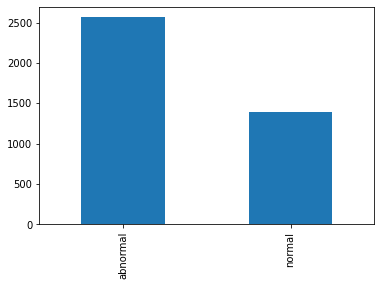

In [7]:
#@title **Label counts: # of Normals & Abnormals**
label_counts = reports_df.label.value_counts()
print('Abnormal:', label_counts['abnormal'])
print('Normal:', label_counts['normal'])
print()
label_counts.plot.bar();

As we see in the bar graph above, there are almost twice as many abnormal reports as there are normal reports. This will be important to remember as we partition our data into training, validation, and test sets.

In fact, we'll go ahead and split off ("hold out") the test set right now to ensure our model is not exposed to it until the very end. 

We'll set it up such that the our test set is 15% of our full data set and keep the relative percentage of labels the same as in our full dataset.

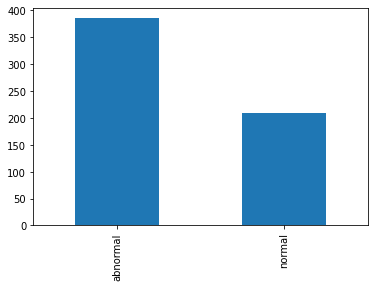

In [9]:
#@title **Test set label counts**
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(reports_df, test_size=0.15, stratify=reports_df.label.values)
test_counts = test.label.value_counts()
test_counts.plot.bar();

# Language Modeling

The types of algorithms we use in NLP work with with numbers, not text. Therefore, we need a way to convert text into numbers.

## Tokenization

_Tokenization_ is the process by which we split text into chunks or _tokens_. An individual token could be a sentence or phrase, a word, a part of a word, or a single character. Most often, we choose to tokenize at the word or sub-word level.

Each token is assigned a sequential integer value and the collection of token-integer pairs is called our _vocabulary_.

## Embedding

While these integers map one-to-one onto our tokens, their numeric value is otherwise meaningless. To embed more information into the numeric representation of our tokens, we employ a process called _language modeling_. We can either use a pre-trained language model for this _embedding_ or we can fine-tune a language model to better model our "radiology language". This latter process is called _transfer learning_.

In [ ]:
#@title **Word vs. Sub-word Tokenization**

from fastai.text.all import *

# Pick back up here...